# 07_Spatial_Gaussian_Kernel

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
import os
import simba as si
si.__version__

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_si

'1.2'

In [4]:
workdir = 'data/07'
si.settings.set_workdir(workdir)

Saving results in: data/07


In [5]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Spatial entity

In [6]:
h5_fn = "./result_simba_rnaseq_spatialLIBD/data/151673.h5ad"
adata_CG = sc.read_h5ad(h5_fn)
adata_CG

AnnData object with n_obs × n_vars = 3611 × 16578
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
spots = adata_CG.obsm['spatial'].copy()
sorted_points = np.lexsort((spots[:, 0], spots[:, 1]))
spots = spots[sorted_points]

In [10]:
diff = spots[:, np.newaxis, :] - spots[np.newaxis, :, :]
diff.shape

(3611, 3611, 2)

In [11]:
squared_distances = np.sum(diff**2, axis=2)
squared_distances.shape

(3611, 3611)

Get minimum distance between non-identical points

In [37]:
min_dists = np.sort(np.sort(squared_distances)[:, 1])
min_dists

array([ 18769,  18769,  18769, ...,  19265,  19265, 171937])

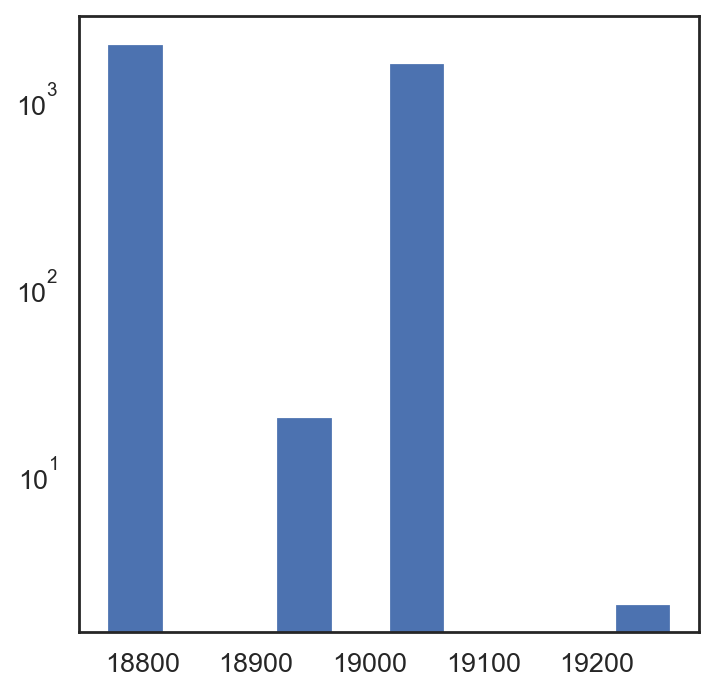

In [38]:
plt.hist(min_dists[:-1]) # remove one outlier
plt.yscale('log')
plt.show()

## Nearest neighbors distance + probability

$$\Sigma_l(i, i') = \sigma_0^2 \tau_l K(s, s')$$
$$K(s, s') = \exp{(-\frac{|s - s'|^2}{\gamma})}$$

If we want nearest neighbors to get at least percent $p$ of probability/weight:

$$p = \exp{(-\frac{|s - s'|^2}{\gamma})}$$
$$\ln p = -\frac{|s - s'|^2}{\gamma}$$
$$\gamma = -\frac{|s - s'|^2}{\ln p}$$

In [44]:
neighbor_dists = np.sort(squared_distances)[:, 1:7] # 6 nearest points excluding the point itself
neighbor_dists

array([[ 19045,  19061,  76096, 133220, 133237, 133922],
       [ 19045,  57077,  57125,  57188,  75629, 132533],
       [ 18922,  19024,  19045,  57077,  75629,  76096],
       ...,
       [ 19024,  19045,  19045,  19061,  56773,  57077],
       [ 18770,  18922,  19024,  19045,  57077,  57601],
       [ 18770,  19024,  56666,  75629,  76577, 132533]])

In [59]:
mean_neighbor_dists = np.mean(neighbor_dists.flatten())
median_neighbor_dists = np.median(neighbor_dists.flatten())

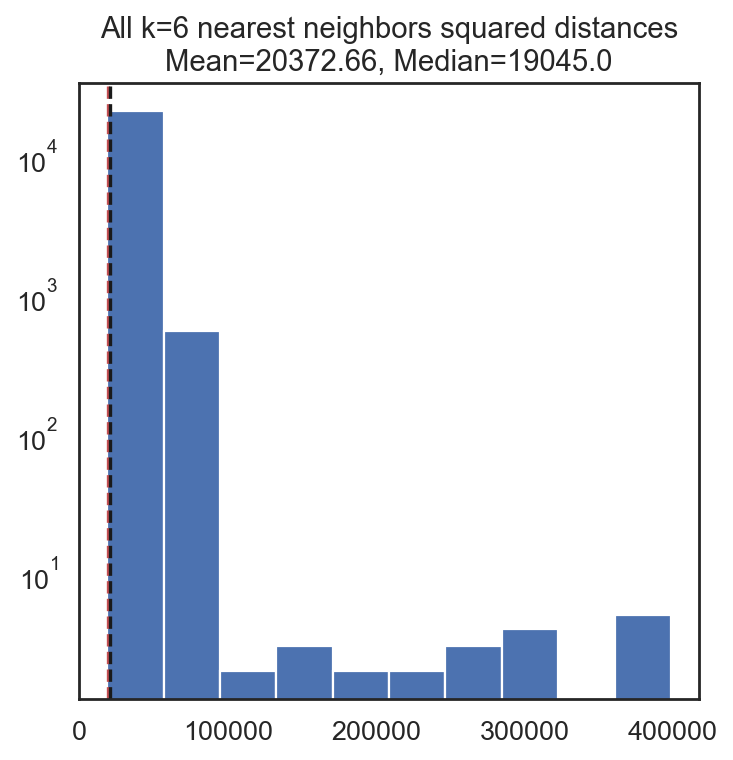

In [64]:
plt.hist(neighbor_dists.flatten())
plt.yscale('log')
plt.title(f'All k=6 nearest neighbors squared distances\nMean={np.round(mean_neighbor_dists, 2)}, Median={median_neighbor_dists}')
plt.axvline(median_neighbor_dists, color='r', linestyle='--')
plt.axvline(mean_neighbor_dists, color='k', linestyle='--')
plt.show()

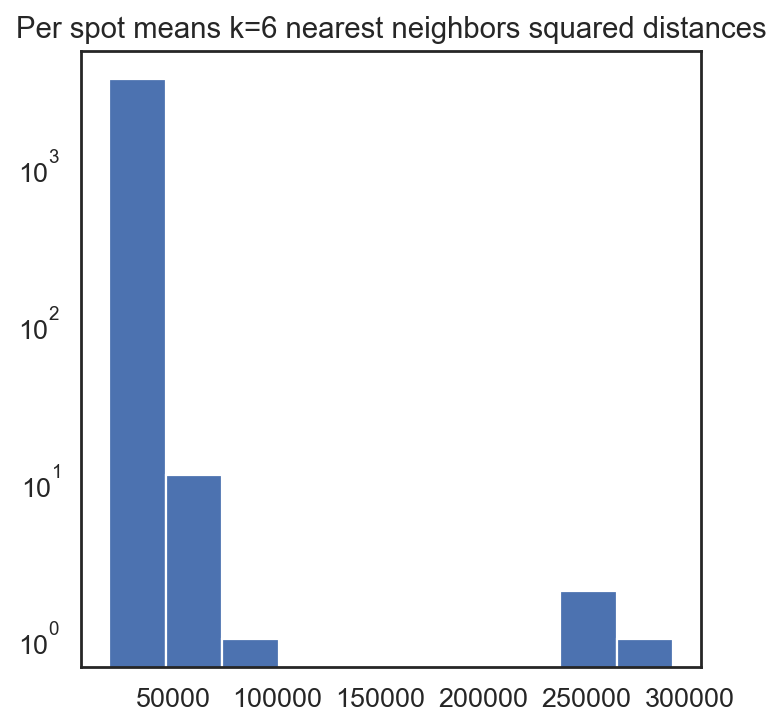

In [57]:
plt.hist(np.mean(neighbor_dists, axis=1))
plt.yscale('log')
plt.title('Per spot means k=6 nearest neighbors squared distances')
plt.show()

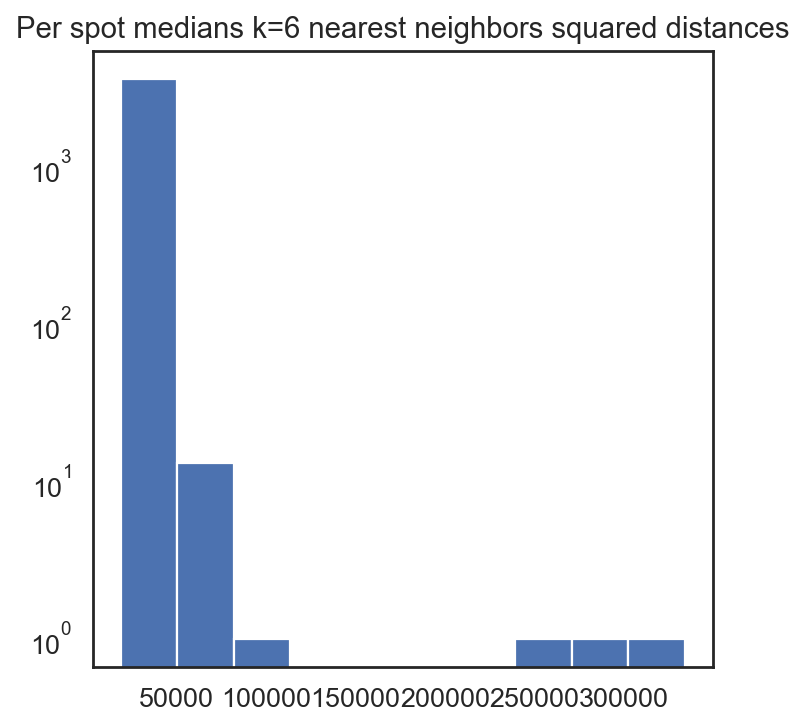

In [58]:
plt.hist(np.median(neighbor_dists, axis=1))
plt.yscale('log')
plt.title('Per spot medians k=6 nearest neighbors squared distances')
plt.show()

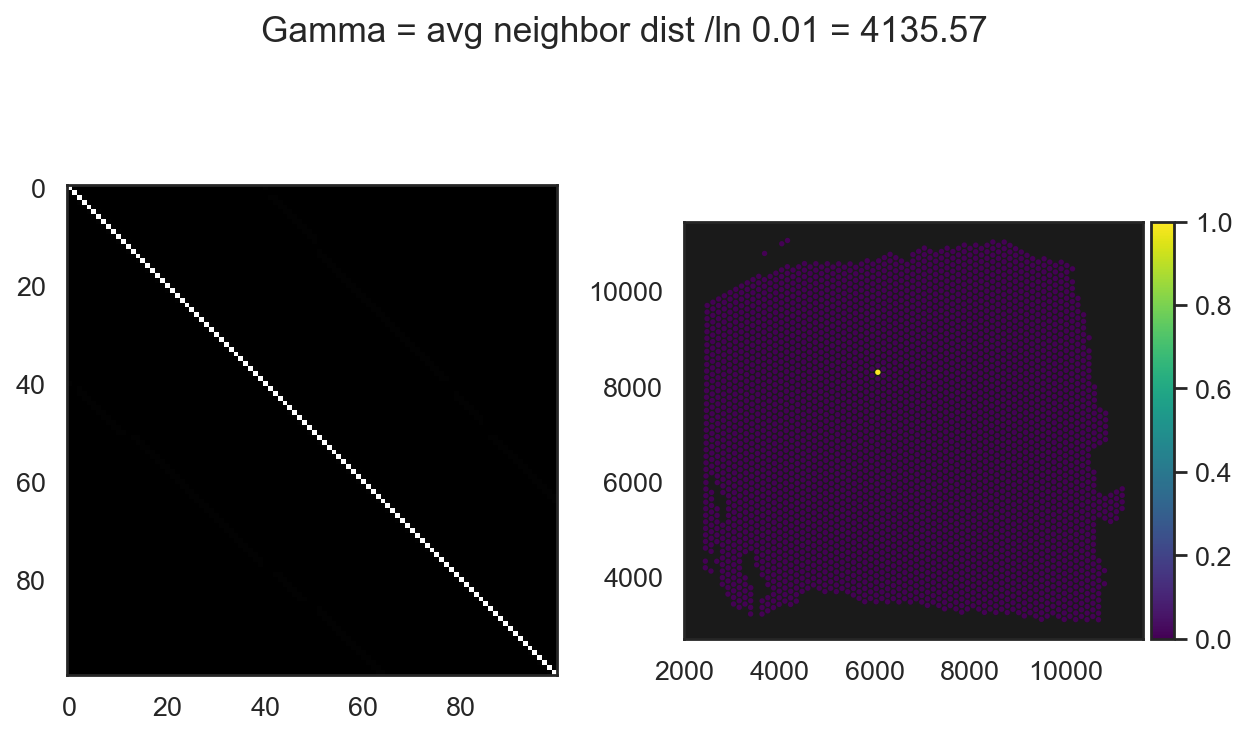

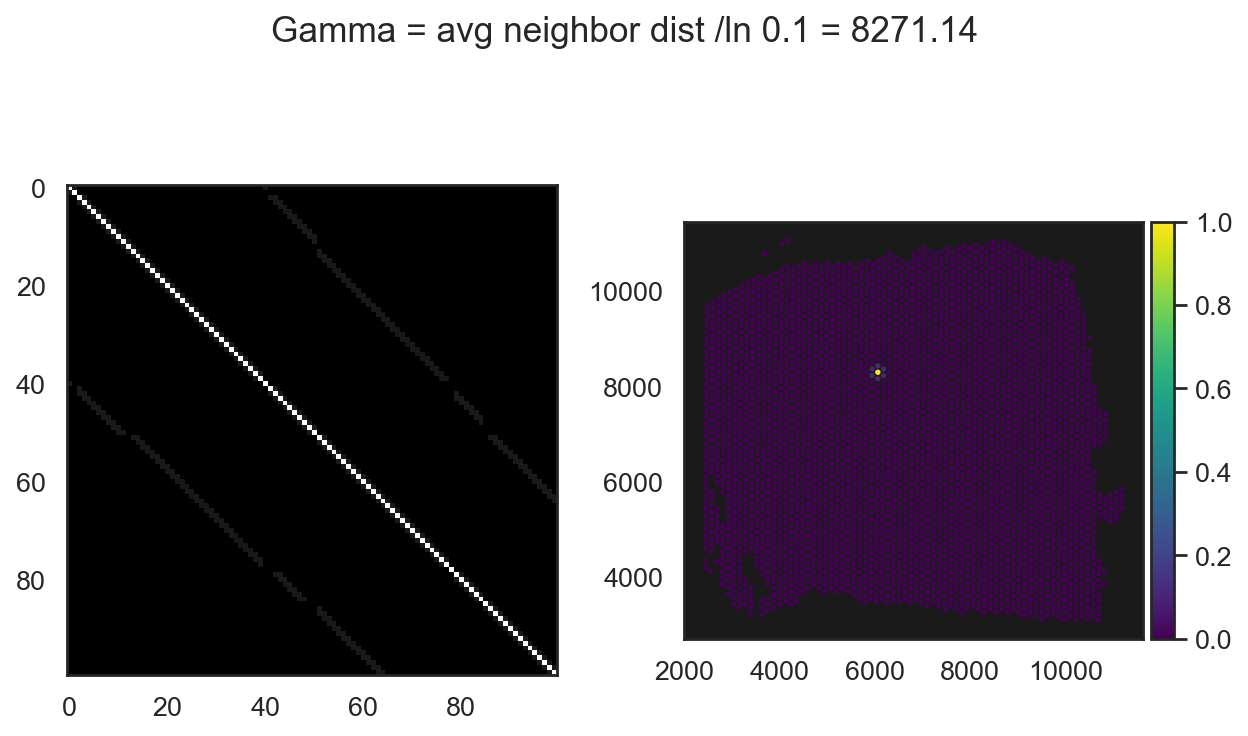

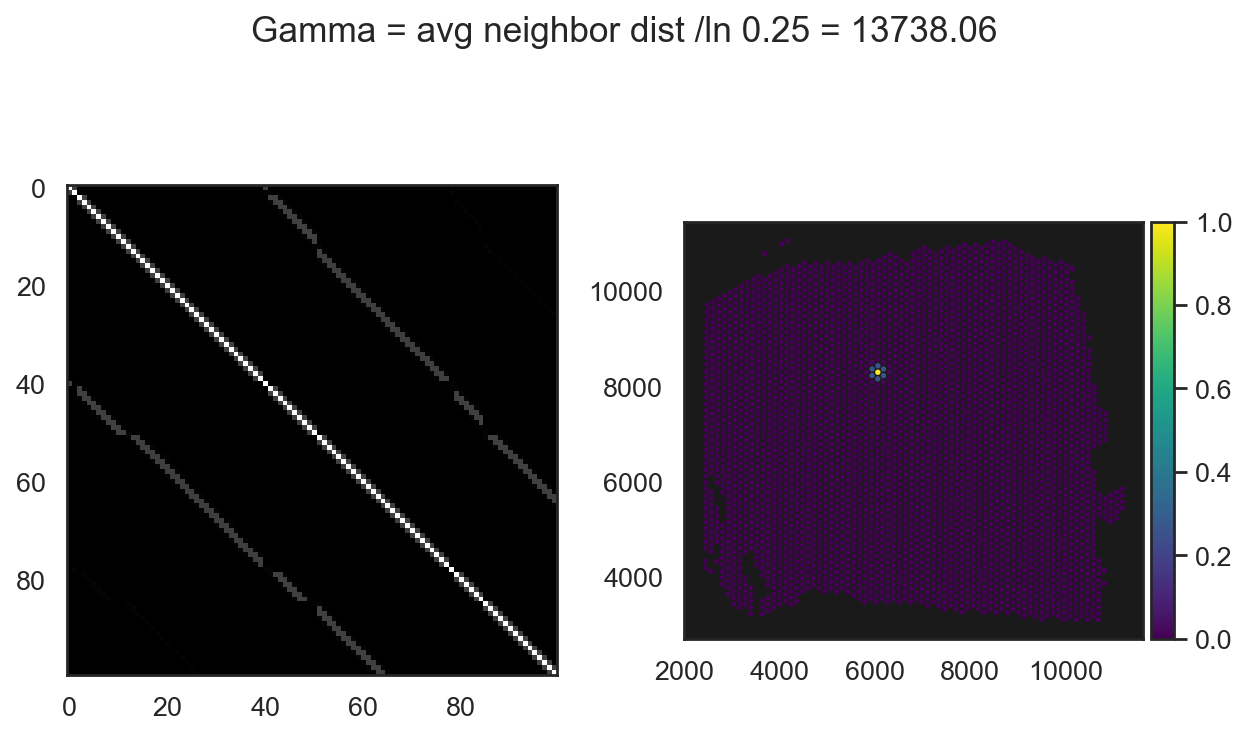

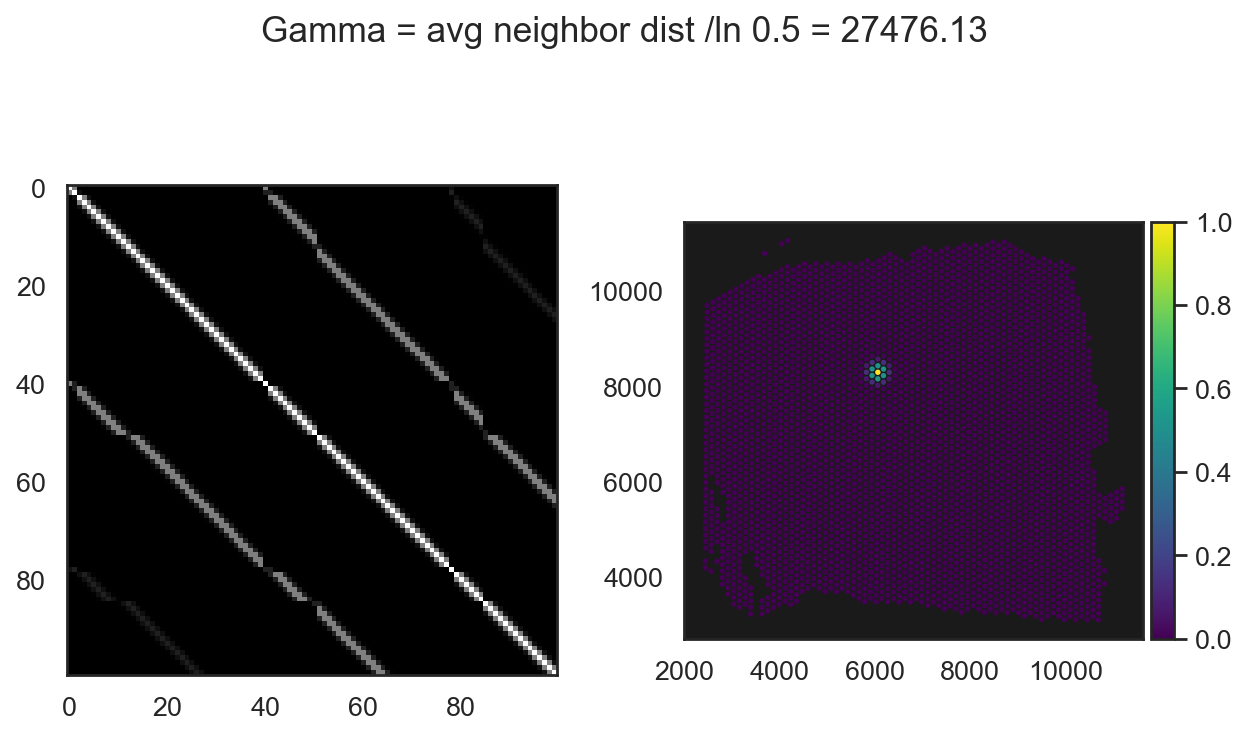

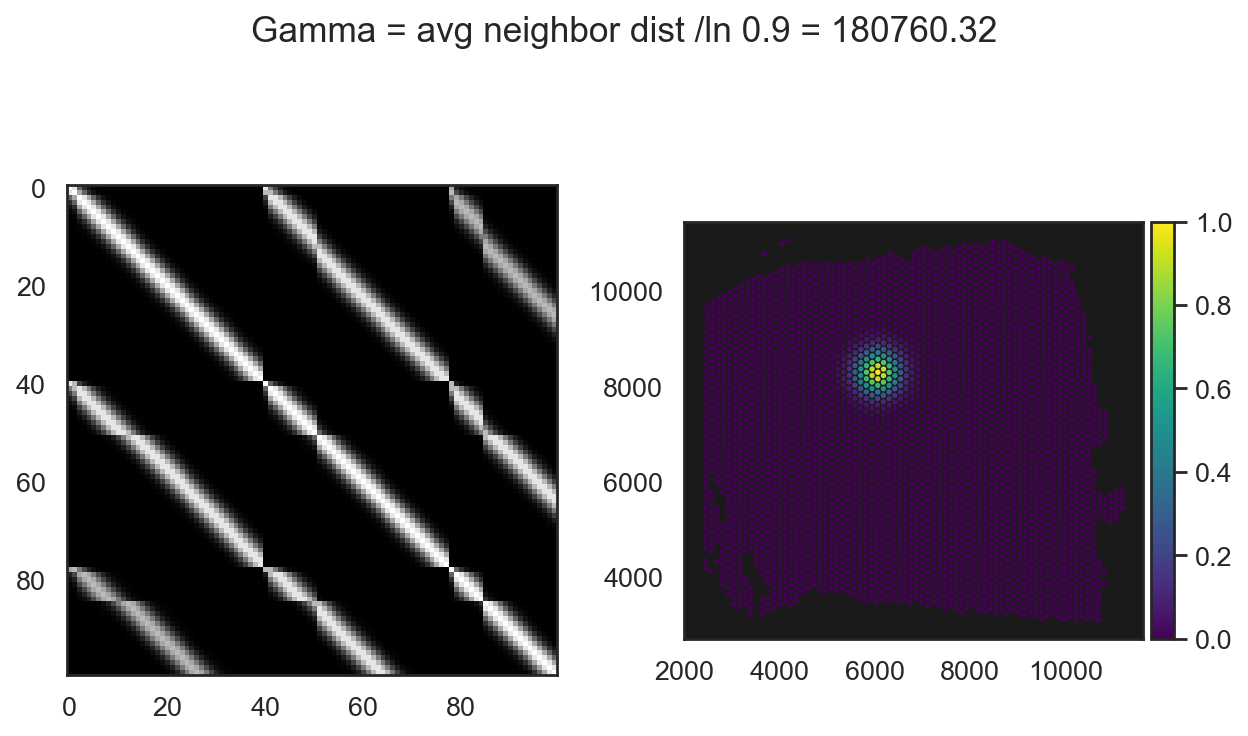

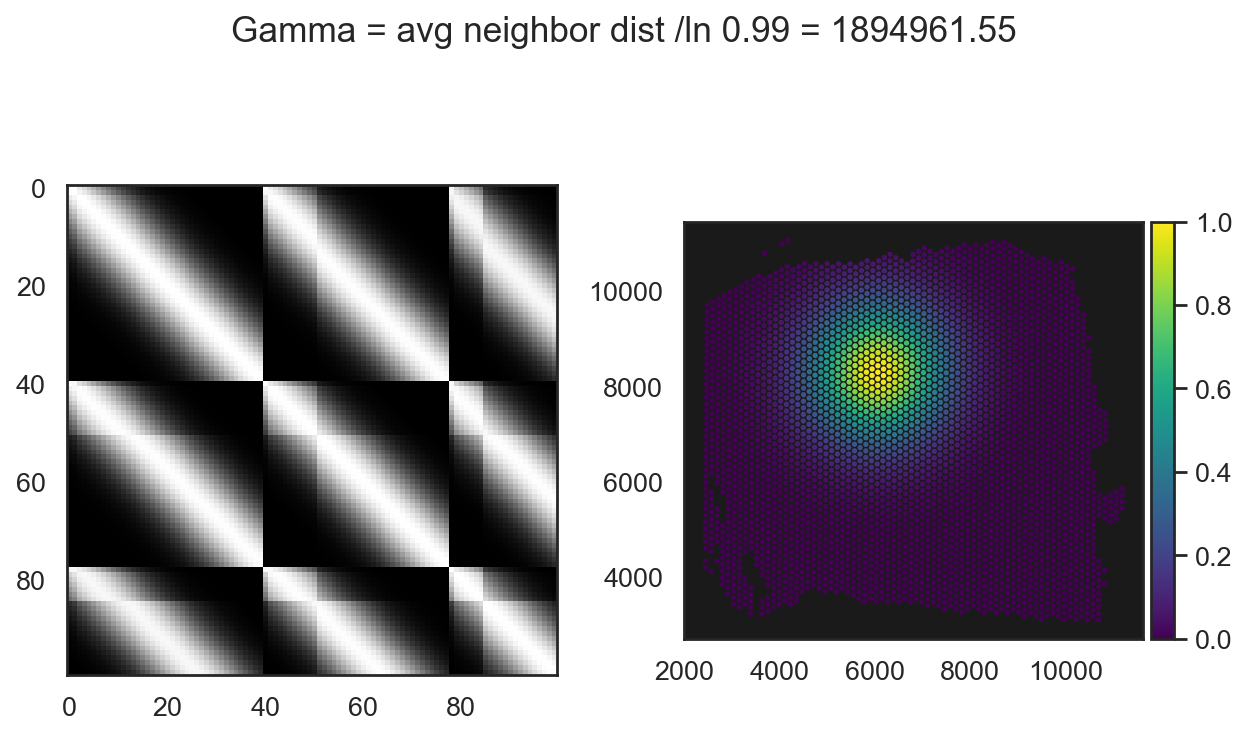

In [76]:
for p in [0.01, 0.1, 0.25, 0.5, 0.9, 0.99]:
    gamma = -median_neighbor_dists / np.log(p)
    kernel_matrix = 1*np.exp(-squared_distances / gamma)
    fig, axes = plt.subplots(1, 2, figsize=(8, 12))
    axes[0].imshow(kernel_matrix[:100, :100], cmap='gray')

    im = axes[1].scatter(spots[:, 1], spots[:, 0], c=kernel_matrix[1500], s=2)
    axes[1].set_facecolor('k')
    axes[1].set_aspect('equal', adjustable='box')
    fig.suptitle(f"Gamma = avg neighbor dist /ln {p} = {np.round(gamma, 2)}", y=0.7)
    
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.tight_layout()
    plt.show()

## Max distance possible

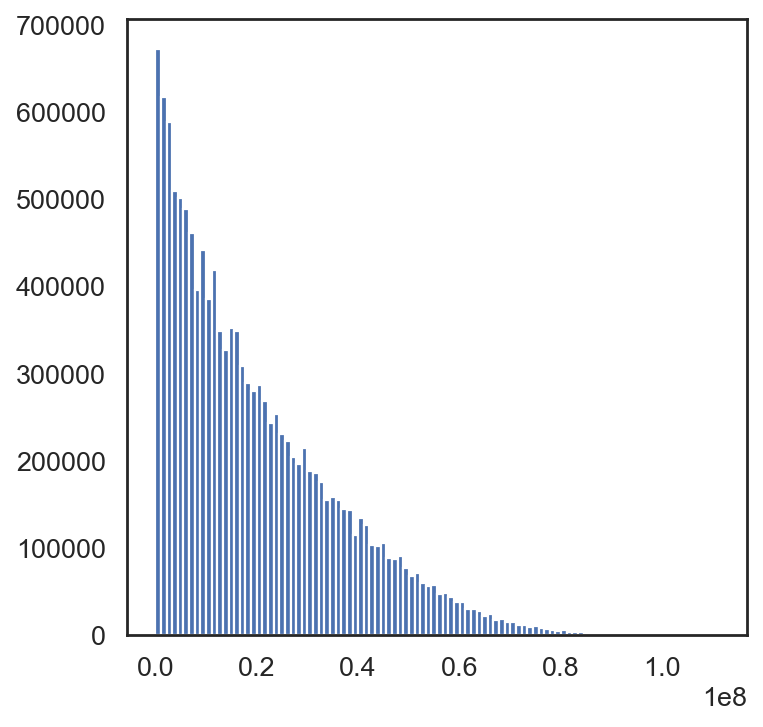

In [12]:
plt.hist(squared_distances.flatten(), bins=100)
plt.show()

Some fraction of the largest distance? In this case, the largest squared distance is ~1e8.

In [14]:
max_squared_distance = np.max(squared_distances)
max_squared_distance

111141601

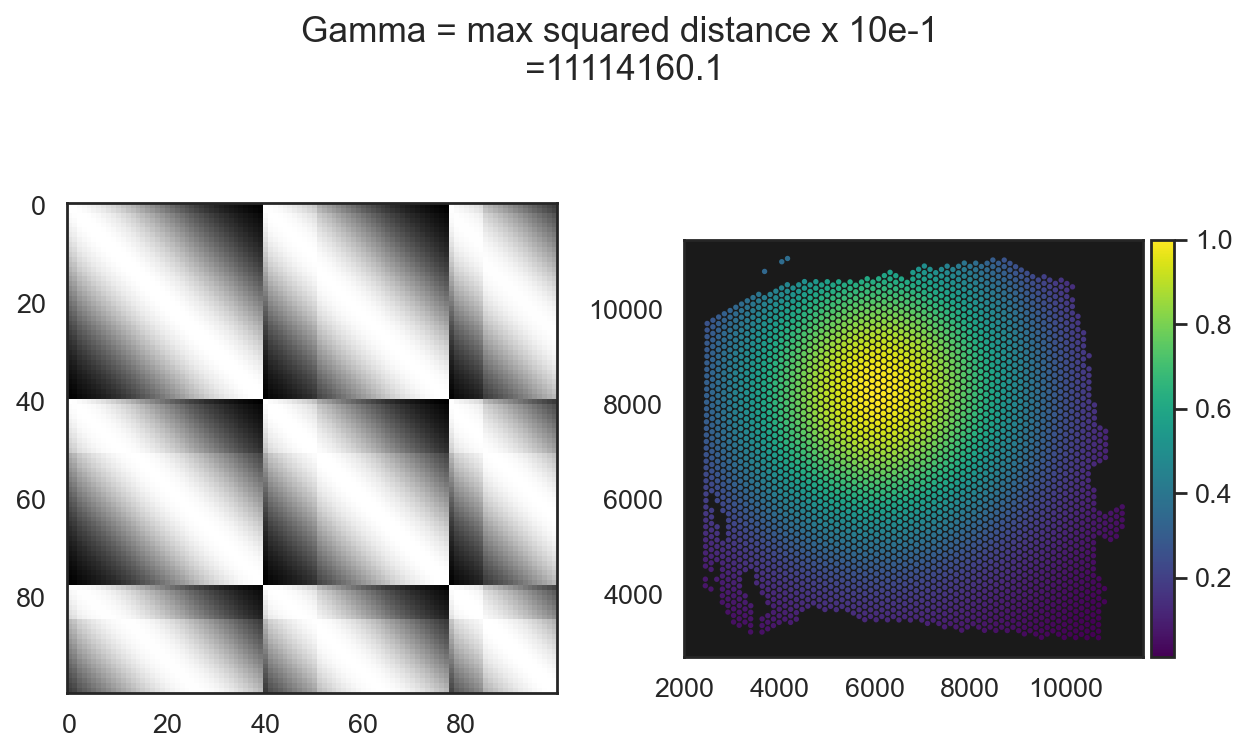

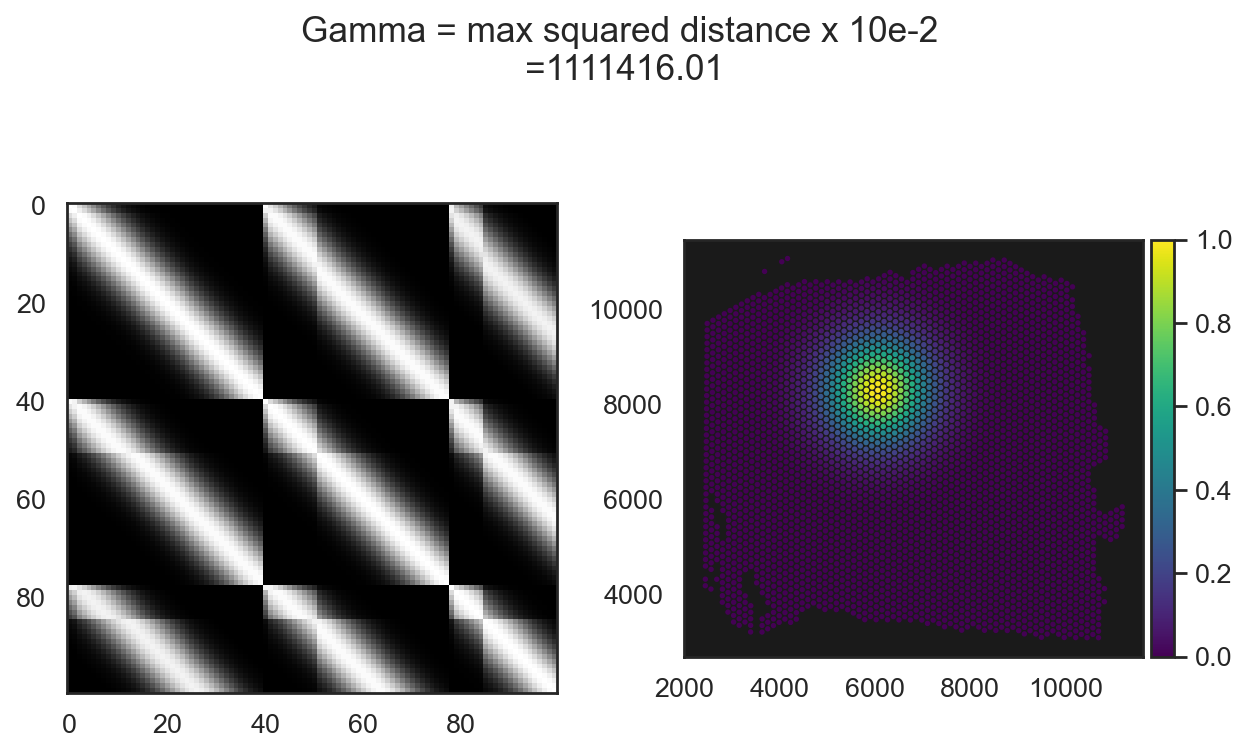

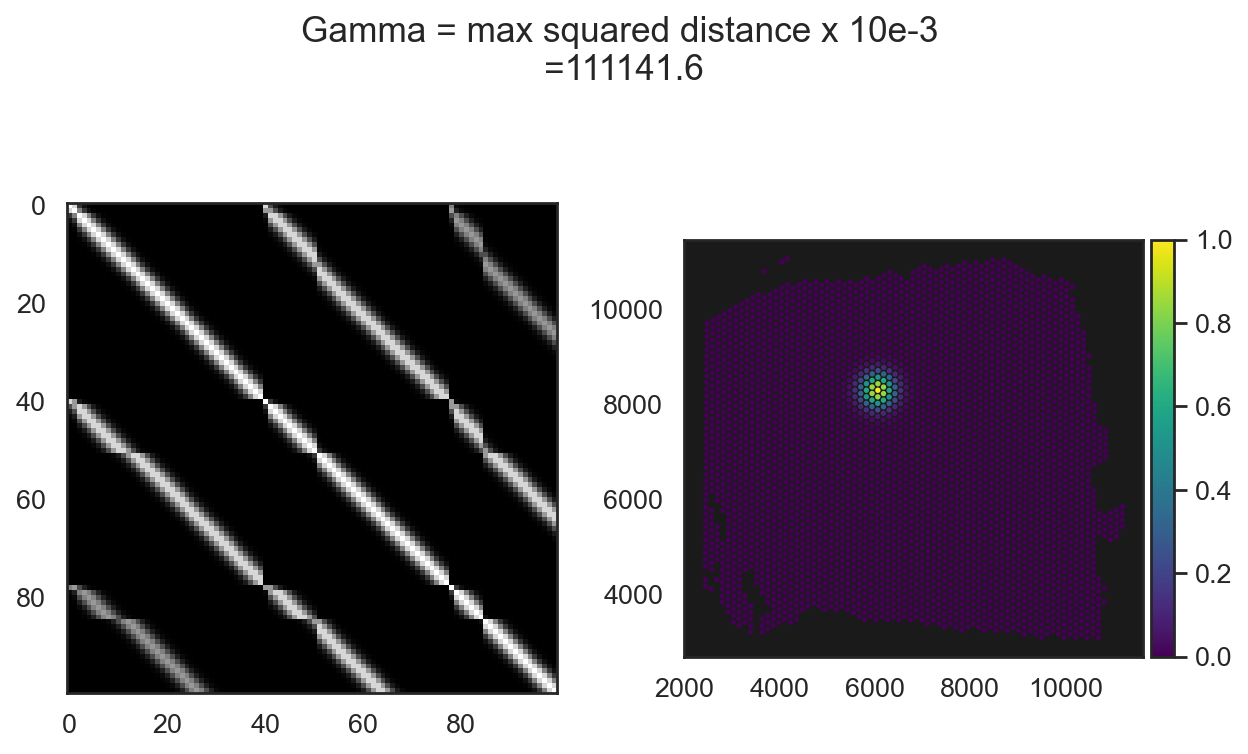

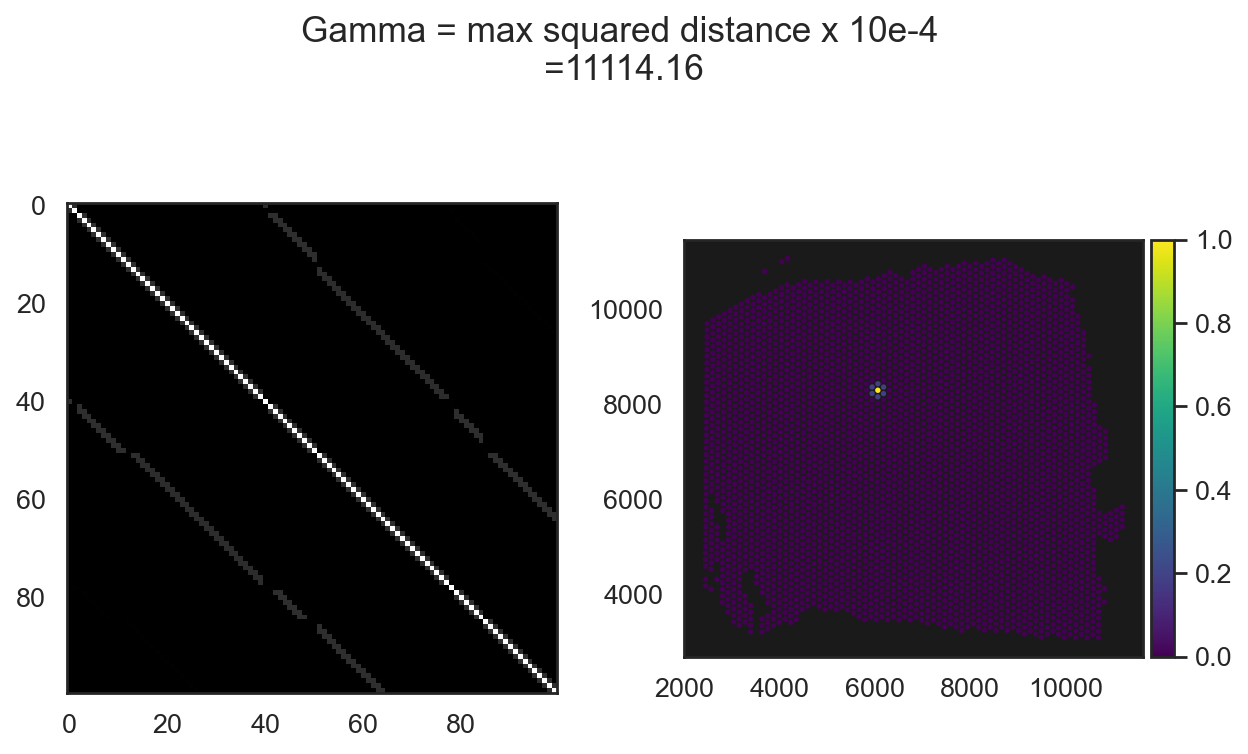

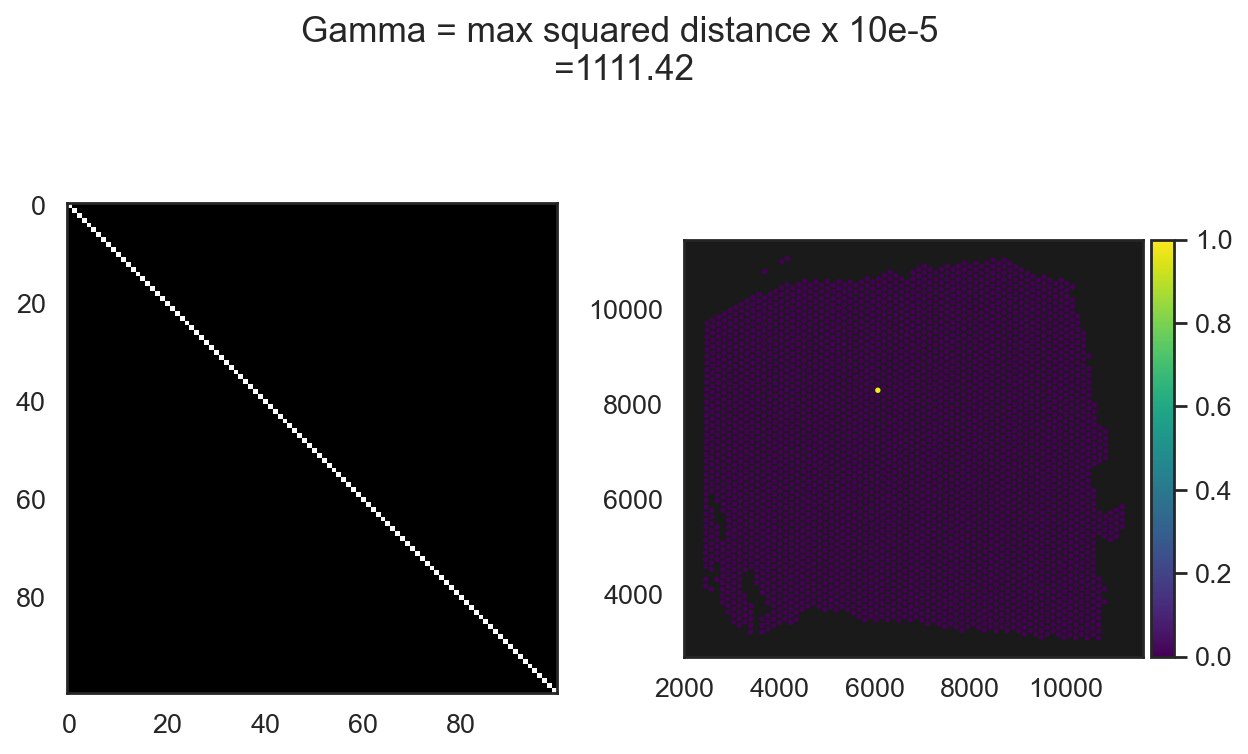

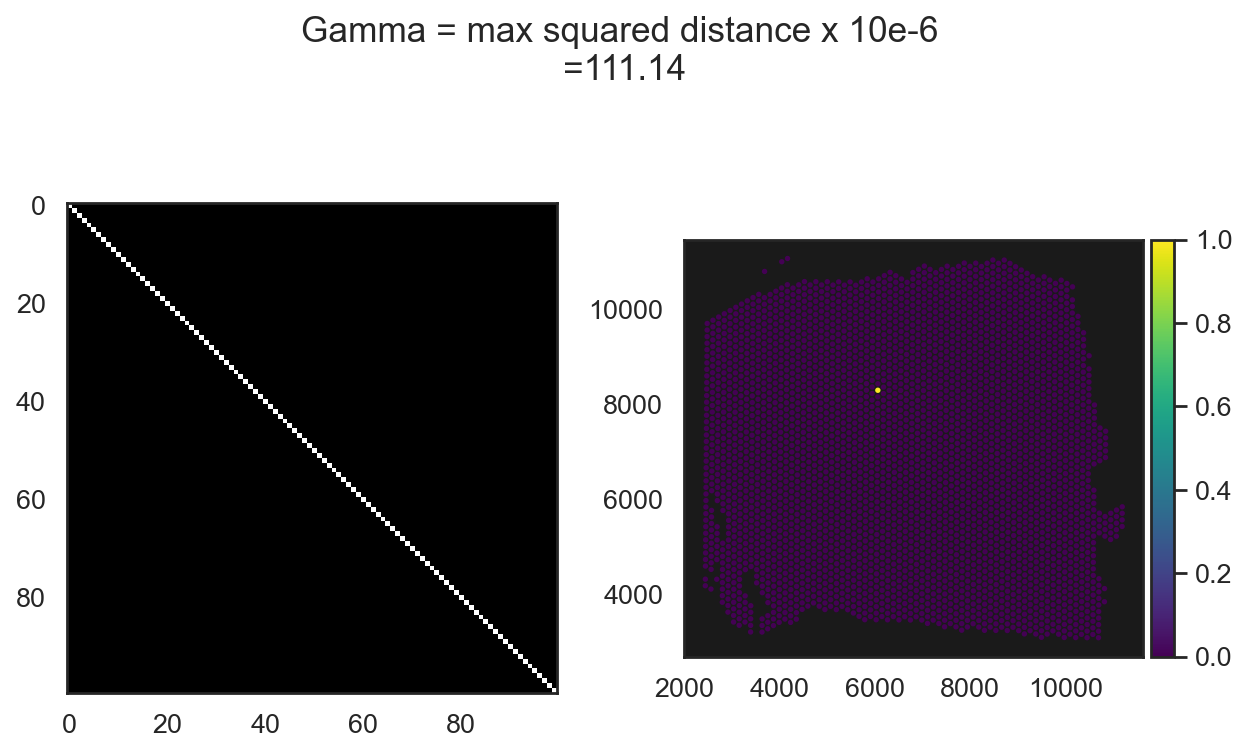

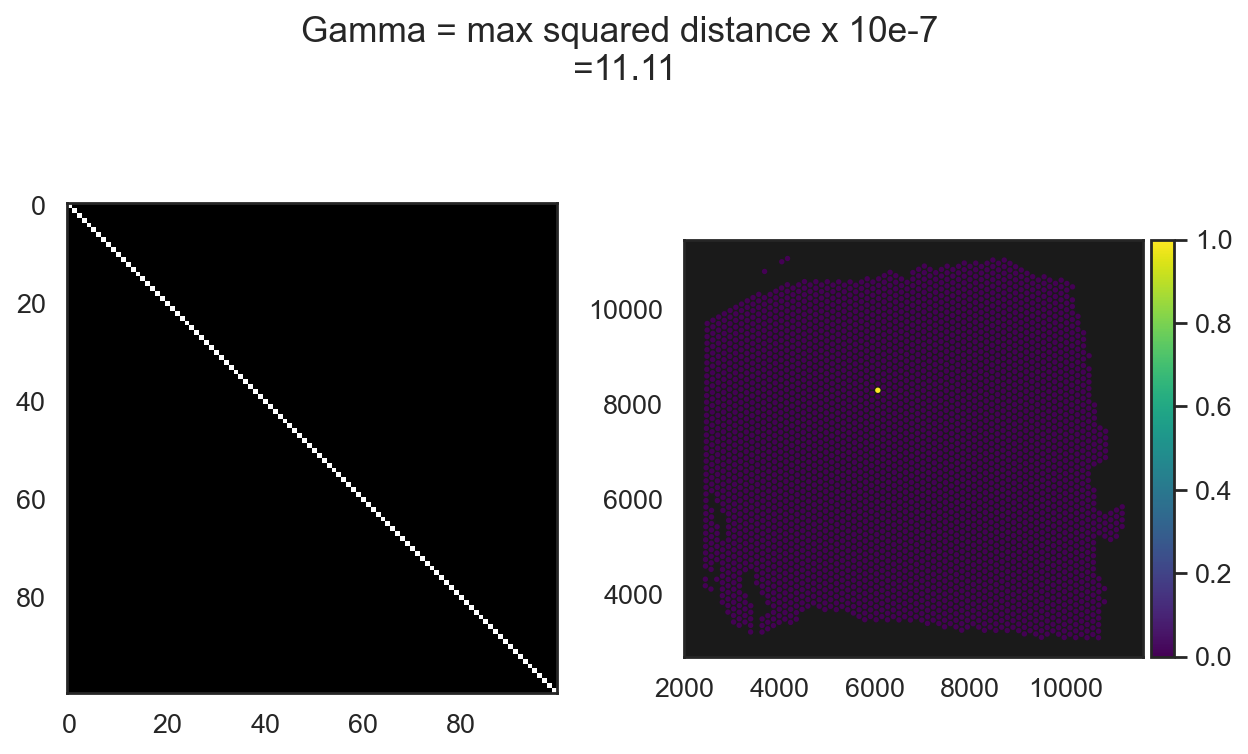

In [77]:
for e in range(1, 8):
    gamma = max_squared_distance * 10**(-e)
    kernel_matrix = 1*np.exp(-squared_distances / gamma)
    fig, axes = plt.subplots(1, 2, figsize=(8, 12))
    axes[0].imshow(kernel_matrix[:100, :100], cmap='gray')

    im = axes[1].scatter(spots[:, 1], spots[:, 0], c=kernel_matrix[1500], s=2)
    axes[1].set_facecolor('k')
    axes[1].set_aspect('equal', adjustable='box')
    fig.suptitle(f"Gamma = max squared distance x 10e-{e} \n={np.round(gamma, 2)}", y=0.7)
    
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.tight_layout()
    plt.show()

# Test SIMBA

Original SpatialPCA uses the gene expression variation as part of estimating the gamma parameter. I do not think we should add this information to the spatial data? We can just weight by gene expression correlation?

In [140]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
from scipy.sparse import csr_matrix

def gen_spatial_graph(
    adata,
    e, # magnitude
    scalar=1, # could be gene expression correlation?
):
    # gaussian kernel
    spots = adata.obsm['spatial']

    squared_distances = get_squared_distances(spots)

    kernel_matrix = gaussian_kernel_matrix(squared_distances, e, scalar)

    adata_CC = ad.AnnData(kernel_matrix)
    adata_CC.layers['simba'] = adata_CC.X

    adata_CC.obs.index = adata.obs_names
    adata_CC.var.index = adata.obs_names
    adata_CC.obs = adata.obs.copy()
    adata_CC.obsm['spatial'] = adata.obsm['spatial'].copy()
    return adata_CC

# ChatGPT:
def get_squared_distances(spots):
    # spots: np.array list of grid points as tuples
    # Generate all grid points as (row, col) pairs
    # spots = np.array([(i, j) for i in range(N) for j in range(N)])
    # Compute the pairwise squared Euclidean distances using broadcasting
    diff = spots[:, np.newaxis, :] - spots[np.newaxis, :, :]
    squared_distances = np.sum(diff**2, axis=2)    
    return squared_distances
    
def gaussian_kernel_matrix(squared_distances, e, scalar):
    # get gamma
    max_squared_distance = np.max(squared_distances)
    gamma = max_squared_distance * 10**(-e)
    
    # Apply the Gaussian kernel
    kernel_matrix = np.exp(-squared_distances / gamma)
    # single value or nxn weight
    kernel_matrix = kernel_matrix * scalar
    return csr_matrix(kernel_matrix, dtype=np.float32)
    

In [141]:
adata_CC = gen_spatial_graph(adata_CG, e = 2)

In [142]:
adata_CC

AnnData object with n_obs × n_vars = 3611 × 3611
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    obsm: 'spatial'
    layers: 'simba'

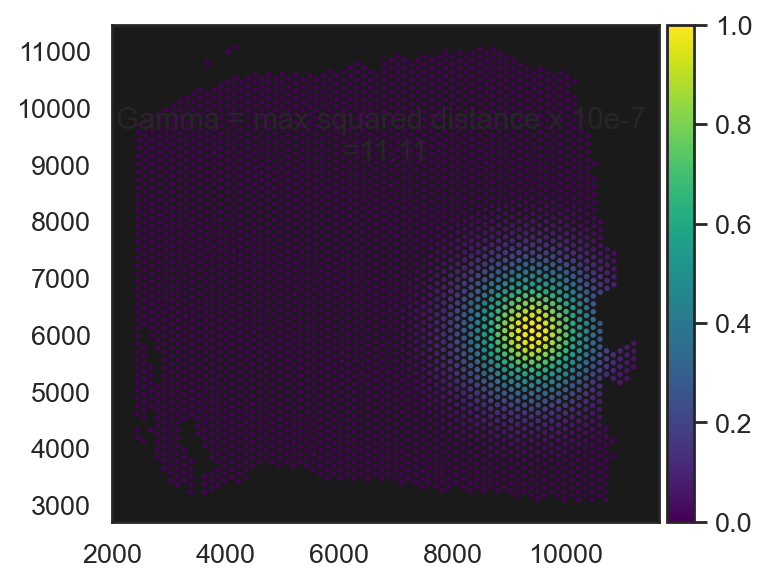

In [143]:
fig, ax = plt.subplots()
im = ax.scatter(adata_CC.obsm['spatial'][:, 1], adata_CC.obsm['spatial'][:, 0], c=adata_CC.layers['simba'].toarray()[1500], s=2)
ax.set_facecolor('k')
ax.set_aspect('equal', adjustable='box')
ax.set_title(f"Gamma = max squared distance x 10e-{e} \n={np.round(gamma, 2)}", y=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

# Generate graph - no gene correlation

## Discretize?

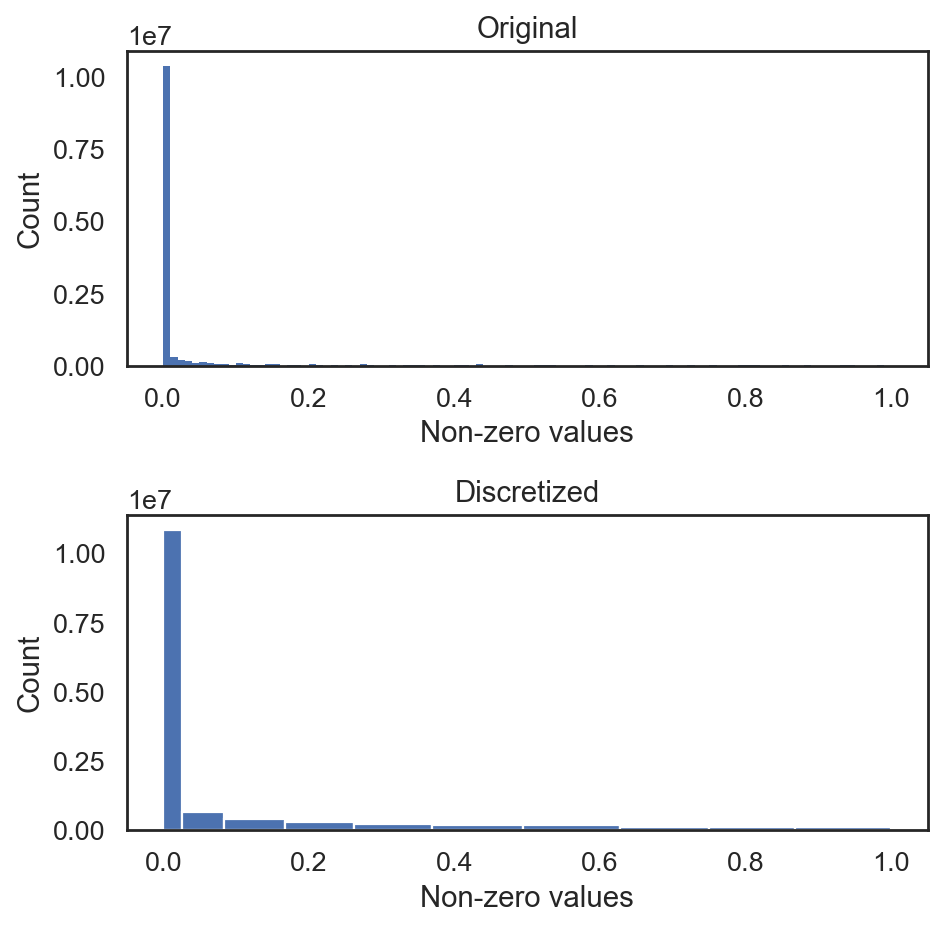

In [95]:
si.tl.discretize(adata_CC,n_bins=10)
si.pl.discretize(adata_CC,kde=False)

In [96]:
si.tl.gen_graph(
    list_adata=[adata_CC],
    prefix='C',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph0'
)

relation0: source: C0, destination: C0
#edges: 13039321
Total number of edges: 13039321
Writing graph file "pbg_graph.txt" to "data/07/pbg/graph0" ...
Finished.


In [97]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.002718
Weight decay being used for training is 0.002718
Converting input data ...
[2025-01-24 16:21:04.508599] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-01-24 16:21:04.509100] These files are in: data/07/pbg/graph0/input/entity, data/07/pbg/graph0/input/edge
Starting training ...


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


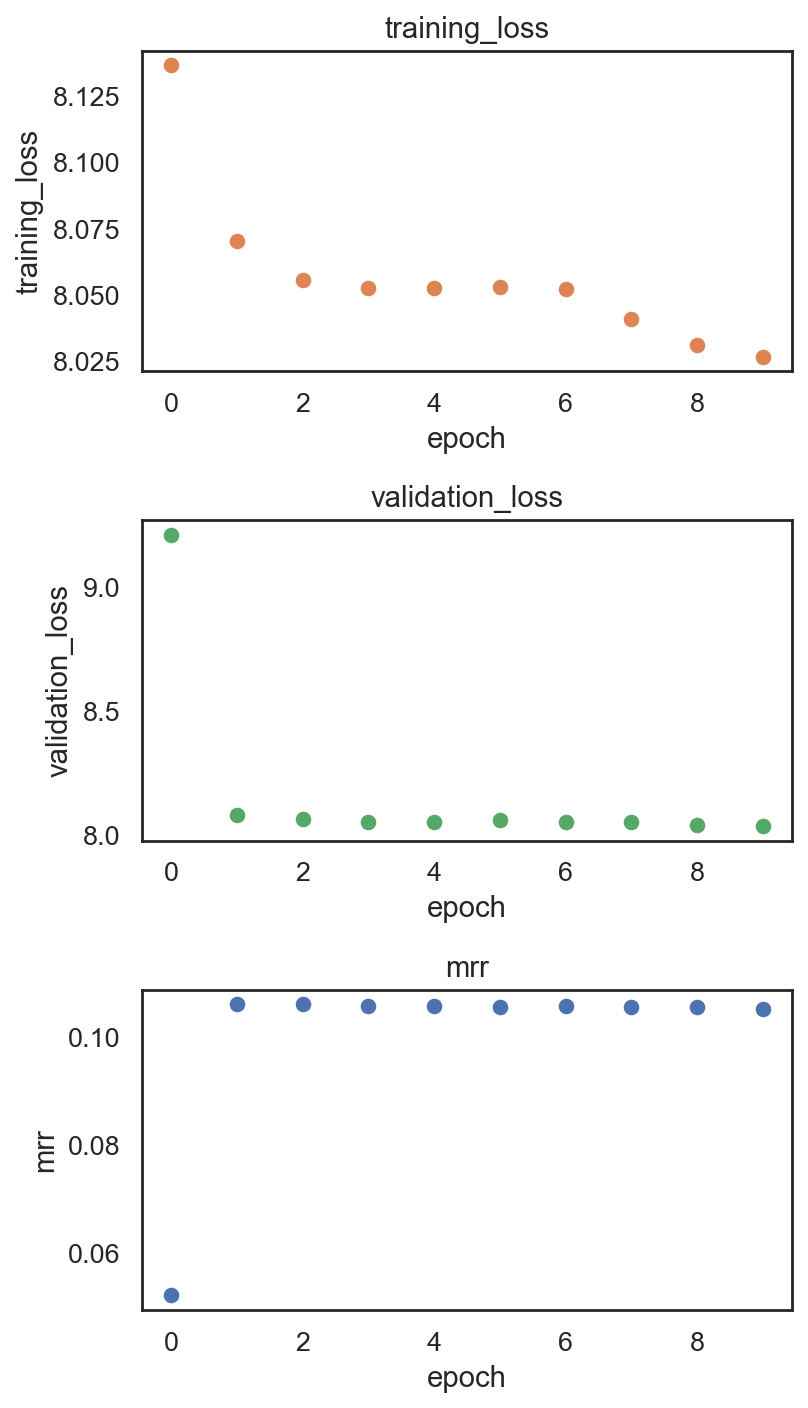

In [98]:
si.pl.pbg_metrics(fig_ncol=1)

In [99]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'C0': AnnData object with n_obs × n_vars = 3611 × 50}

In [100]:
adata_C0 = dict_adata['C0']  # embeddings of cells

In [102]:
adata_C0.obs['spatialLIBD'] = adata_CG[adata_C0.obs_names,:].obs['spatialLIBD'].copy()
adata_C0.var.index = adata_C0.obs.index

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


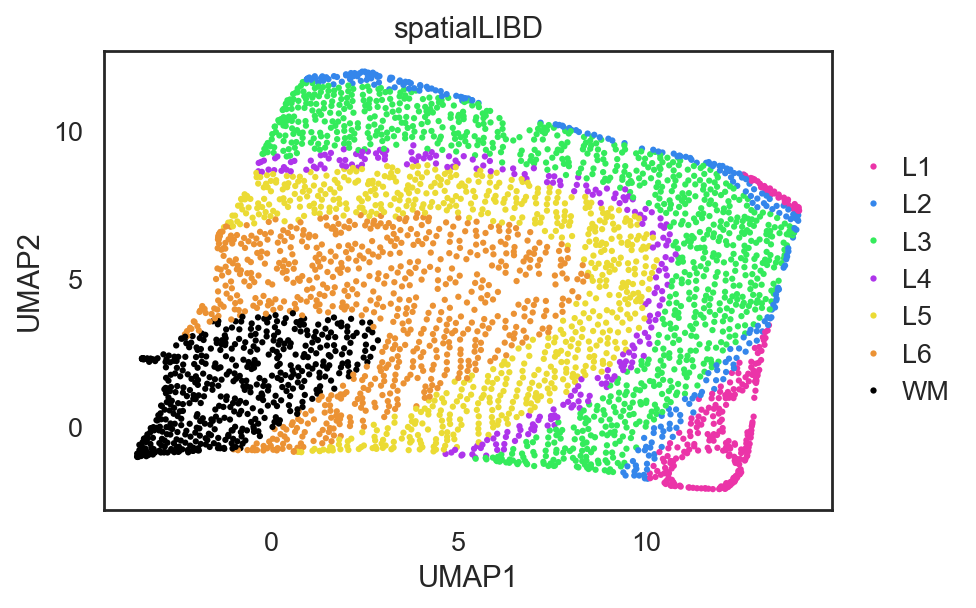

In [103]:
si.tl.umap(adata_C0,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C0,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

# Gene expression correlation weights

In [162]:
corrcoef_cov = np.corrcoef(adata_CG.X.toarray())

In [163]:
corrcoef_cov.shape

(3611, 3611)

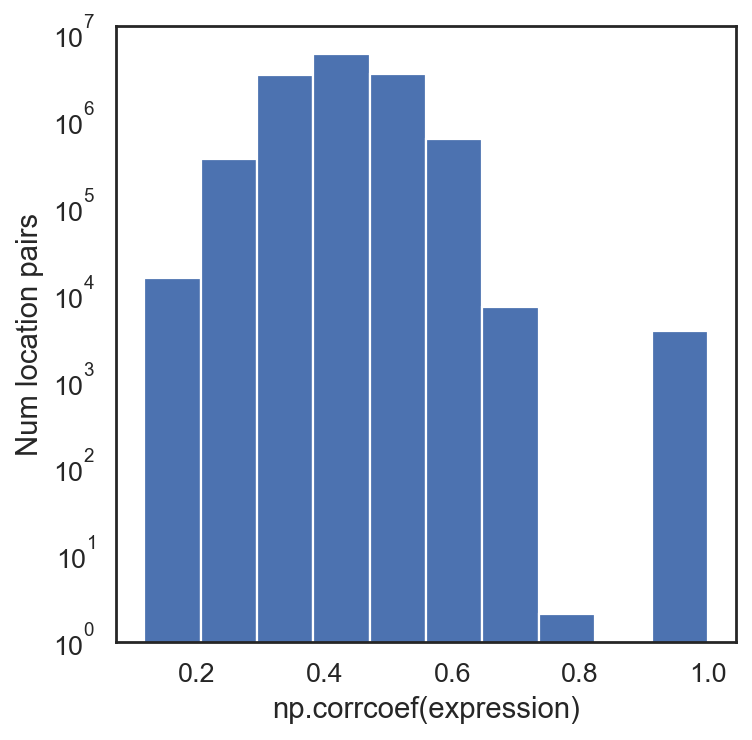

In [164]:
plt.hist(corrcoef_cov.flatten())
plt.xlabel('np.corrcoef(expression)')
plt.ylabel('Num location pairs')
plt.yscale('log')
plt.show()

In [147]:
corrcoef_cov

array([[1.        , 0.37856051, 0.41432623, ..., 0.44638684, 0.39845834,
        0.54435564],
       [0.37856051, 1.        , 0.29881894, ..., 0.31775392, 0.29262276,
        0.35818358],
       [0.41432623, 0.29881894, 1.        , ..., 0.38503864, 0.38054975,
        0.38077176],
       ...,
       [0.44638684, 0.31775392, 0.38503864, ..., 1.        , 0.35505837,
        0.40136814],
       [0.39845834, 0.29262276, 0.38054975, ..., 0.35505837, 1.        ,
        0.37460746],
       [0.54435564, 0.35818358, 0.38077176, ..., 0.40136814, 0.37460746,
        1.        ]])

In [159]:
adata_CC_corr = gen_spatial_graph(adata_CG, e = 2, scalar=corrcoef_cov)

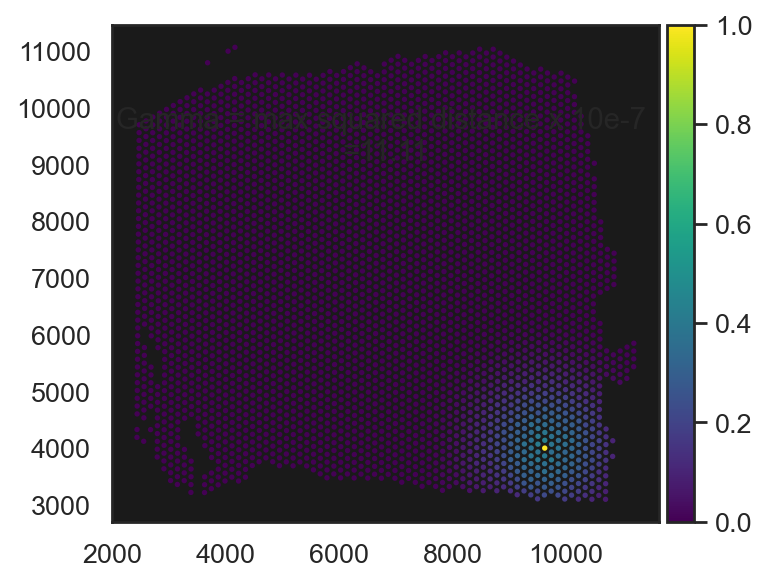

In [155]:
fig, ax = plt.subplots()
im = ax.scatter(adata_CC_corr.obsm['spatial'][:, 1], adata_CC_corr.obsm['spatial'][:, 0], c=adata_CC_corr.layers['simba'].toarray()[1700], s=2)
ax.set_facecolor('k')
ax.set_aspect('equal', adjustable='box')
ax.set_title(f"Gamma = max squared distance x 10e-{e} \n={np.round(gamma, 2)}", y=0.7)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

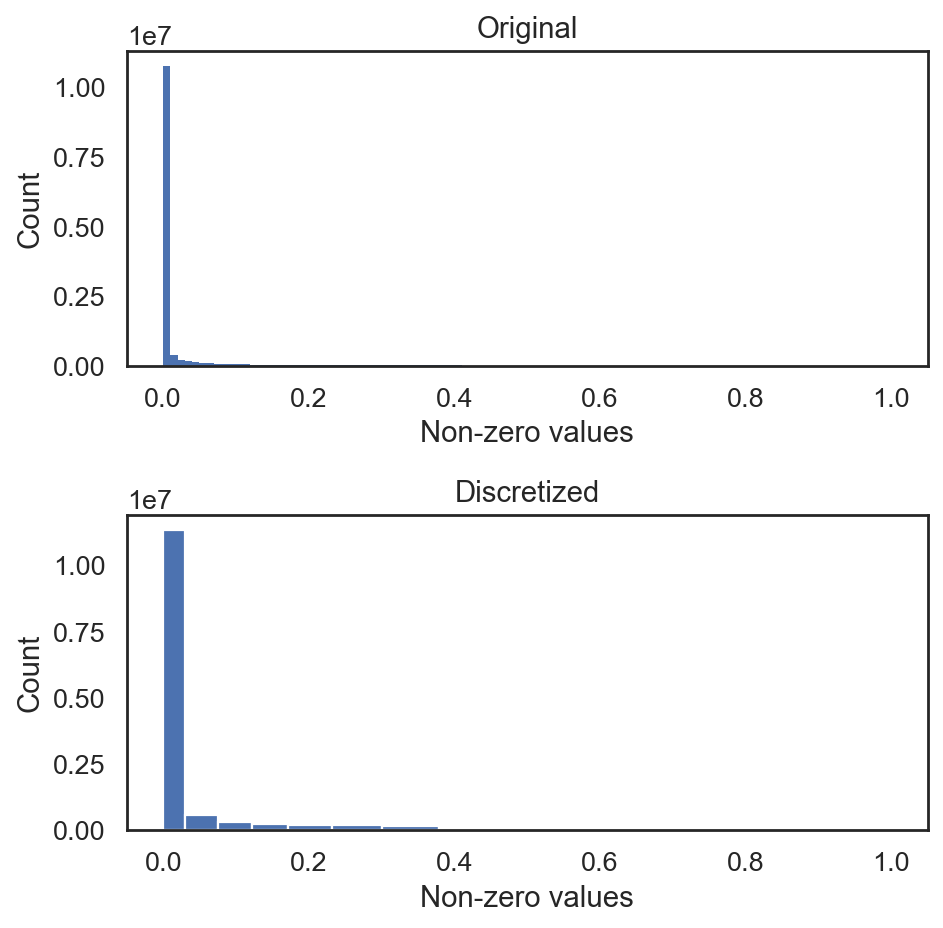

In [123]:
si.tl.discretize(adata_CC_corr,n_bins=10)
si.pl.discretize(adata_CC_corr,kde=False)

In [124]:
si.tl.gen_graph(
    list_adata=[adata_CC_corr],
    prefix='C',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph0_corr'
)

relation0: source: C0, destination: C0
#edges: 13039321
Total number of edges: 13039321
Writing graph file "pbg_graph.txt" to "data/07/pbg/graph0_corr" ...
Finished.


In [125]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_corr')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.002718
Weight decay being used for training is 0.002718
Converting input data ...
[2025-01-24 16:34:11.103080] Using the 1 relation types given in the config
[2025-01-24 16:34:11.103675] Searching for the entities in the edge files...
[2025-01-24 16:34:22.417782] Entity type C0:
[2025-01-24 16:34:22.418271] - Found 3611 entities
[2025-01-24 16:34:22.419594] - Removing the ones with fewer than 1 occurrences...
[2025-01-24 16:34:22.420634] - Left with 3611 entities
[2025-01-24 16:34:22.421298] - Shuffling them...
[2025-01-24 16:34:22.425303] Preparing counts and dictionaries for entities and relation types:
[2025-01-24 16:34:22.426762] - Writing count of entity type C0 and partition 0
[2025-01-24 16:34:22.430205] Preparing edge path data/07/pbg/graph0_corr/input/edge, out of the edges found in data/07/pbg/graph0_corr/pbg_graph.txt
using fast version
[2025-01-24 16:34:22.430949] Taking the fast train!
[202

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


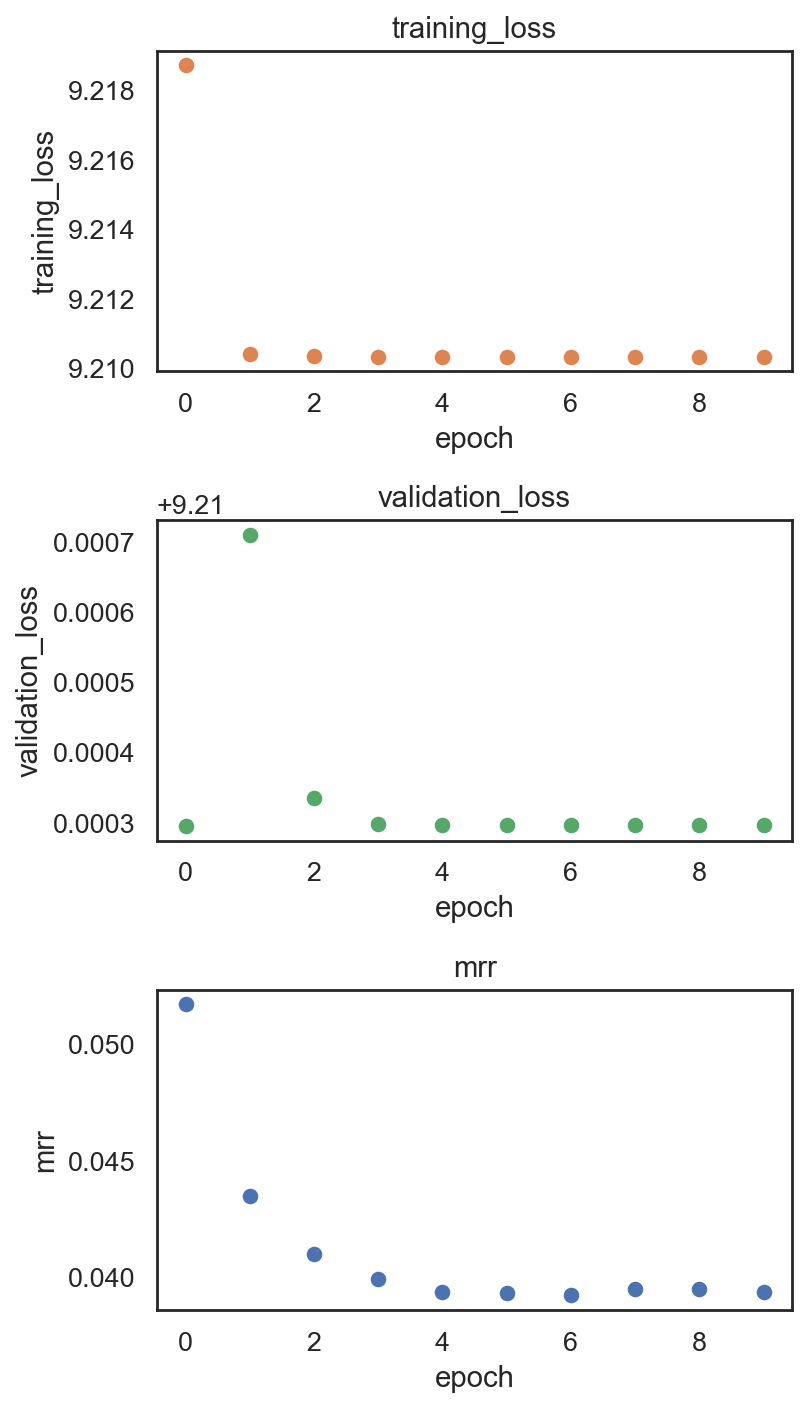

In [126]:
si.pl.pbg_metrics(fig_ncol=1)

In [128]:
# read in entity embeddings obtained from pbg training.
dict_adata_corr = si.read_embedding()
adata_C0_corr = dict_adata_corr['C0']  # embeddings of cells
adata_C0_corr.obs['spatialLIBD'] = adata_CG[adata_C0_corr.obs_names,:].obs['spatialLIBD'].copy()
adata_C0_corr.var.index = adata_C0_corr.obs.index

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


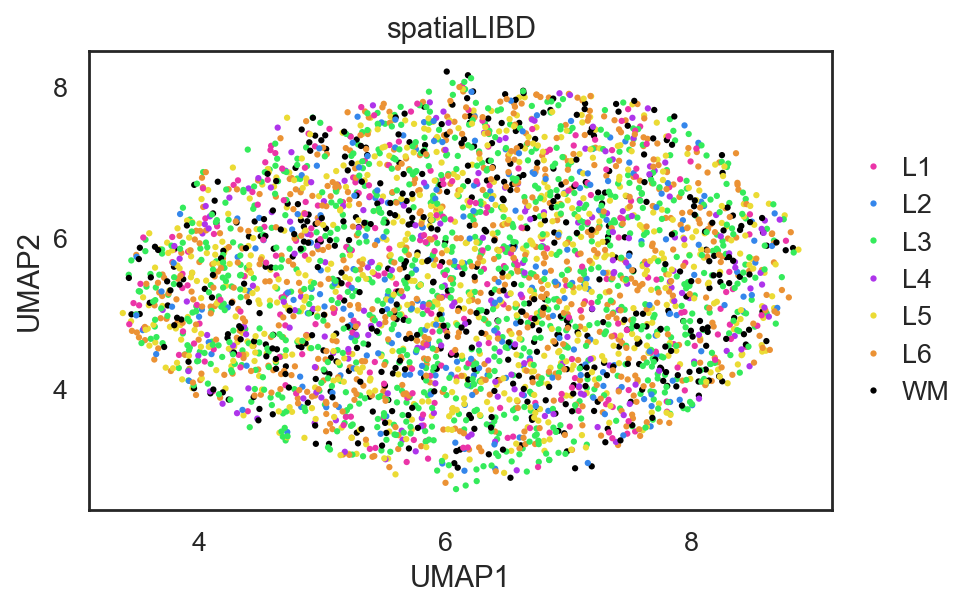

In [129]:
si.tl.umap(adata_C0_corr,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C0_corr,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

## Zero out self edges

In [165]:
diag0_corrcoef_cov = corrcoef_cov.copy()
np.fill_diagonal(diag0_corrcoef_cov, 0)

In [169]:
adata_CC_corr_zero = gen_spatial_graph(adata_CG, e = 2, scalar=diag0_corrcoef_cov)

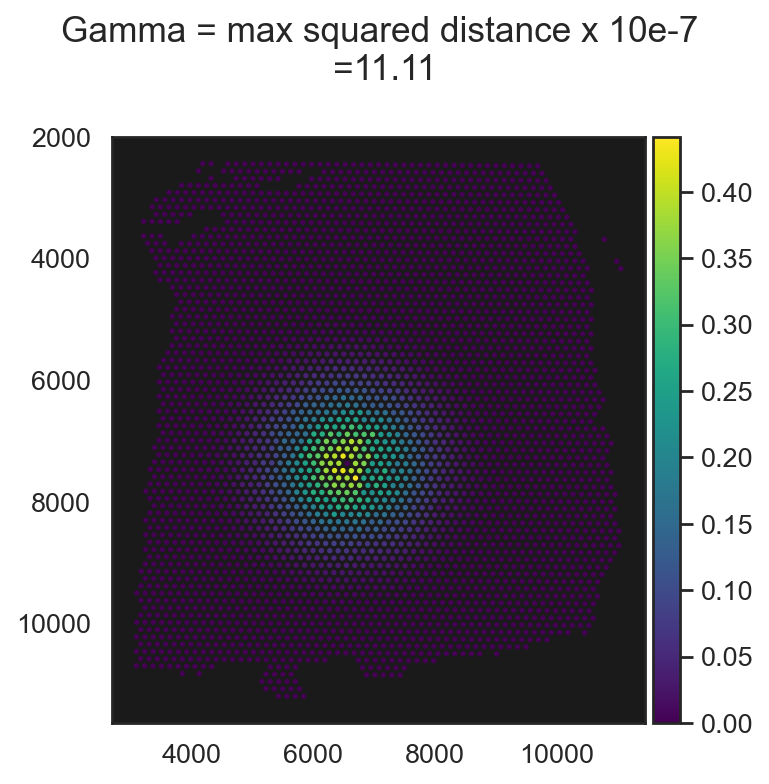

In [193]:
fig, ax = plt.subplots()
im = ax.scatter(adata_CC_corr_zero.obsm['spatial'][:, 0], adata_CC_corr_zero.obsm['spatial'][:, 1], c=adata_CC_corr_zero.layers['simba'].toarray()[1530], s=2)
ax.set_facecolor('k')
ax.set_aspect('equal', adjustable='box')
fig.suptitle(f"Gamma = max squared distance x 10e-{e} \n={np.round(gamma, 2)}")
ax.invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.show()

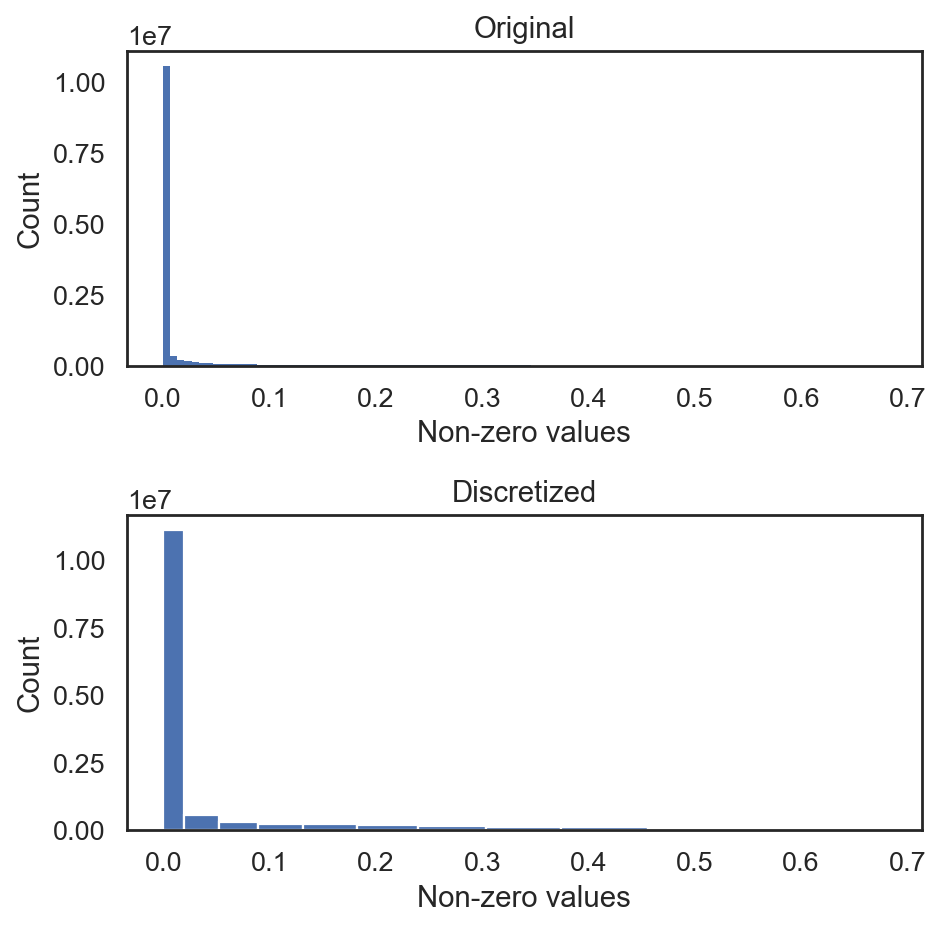

In [194]:
si.tl.discretize(adata_CC_corr_zero,n_bins=10)
si.pl.discretize(adata_CC_corr_zero,kde=False)

In [201]:
si.tl.gen_graph(
    list_adata=[adata_CC_corr_zero],
    prefix='C',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph0_corr_diag0'
)

relation0: source: C0, destination: C0
#edges: 13035710
Total number of edges: 13035710
Writing graph file "pbg_graph.txt" to "data/07/pbg/graph0_corr_diag0" ...
Finished.


In [202]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_corr_diag0')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.002718
Weight decay being used for training is 0.002718
Converting input data ...
[2025-01-28 17:30:27.213957] Using the 1 relation types given in the config
[2025-01-28 17:30:27.214355] Searching for the entities in the edge files...
[2025-01-28 17:30:38.573874] Entity type C0:
[2025-01-28 17:30:38.574339] - Found 3611 entities
[2025-01-28 17:30:38.574724] - Removing the ones with fewer than 1 occurrences...
[2025-01-28 17:30:38.575621] - Left with 3611 entities
[2025-01-28 17:30:38.576137] - Shuffling them...
[2025-01-28 17:30:38.577754] Preparing counts and dictionaries for entities and relation types:
[2025-01-28 17:30:38.579066] - Writing count of entity type C0 and partition 0
[2025-01-28 17:30:38.583669] Preparing edge path data/07/pbg/graph0_corr_diag0/input/edge, out of the edges found in data/07/pbg/graph0_corr_diag0/pbg_graph.txt
using fast version
[2025-01-28 17:30:38.584686] Taking the fast

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


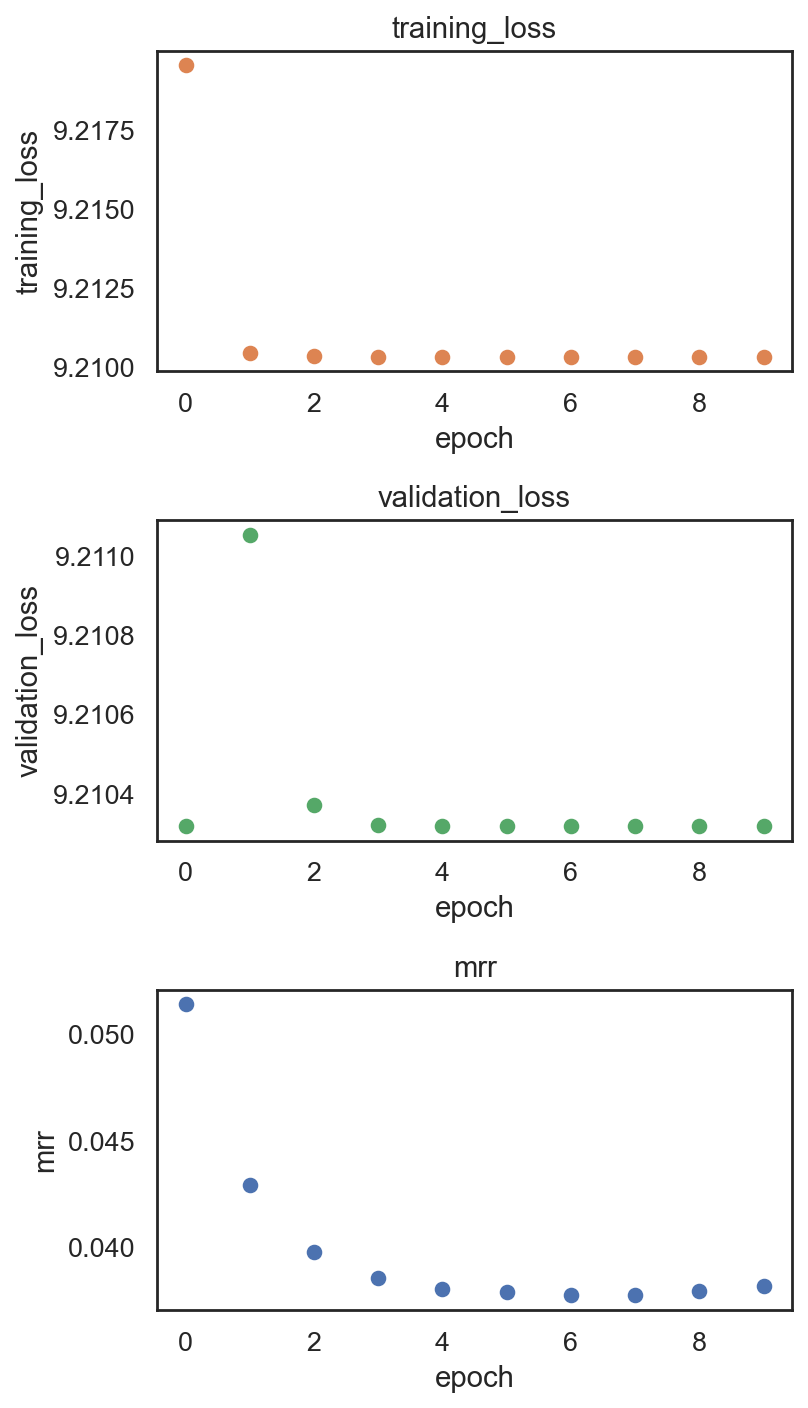

In [203]:
si.pl.pbg_metrics(fig_ncol=1)

In [204]:
# read in entity embeddings obtained from pbg training.
dict_adata_corr_zero = si.read_embedding()
adata_C0_corr_zero = dict_adata_corr['C0']  # embeddings of cells
adata_C0_corr_zero.obs['spatialLIBD'] = adata_CG[adata_C0_corr_zero.obs_names,:].obs['spatialLIBD'].copy()
adata_C0_corr_zero.var.index = adata_C0_corr_zero.obs.index

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


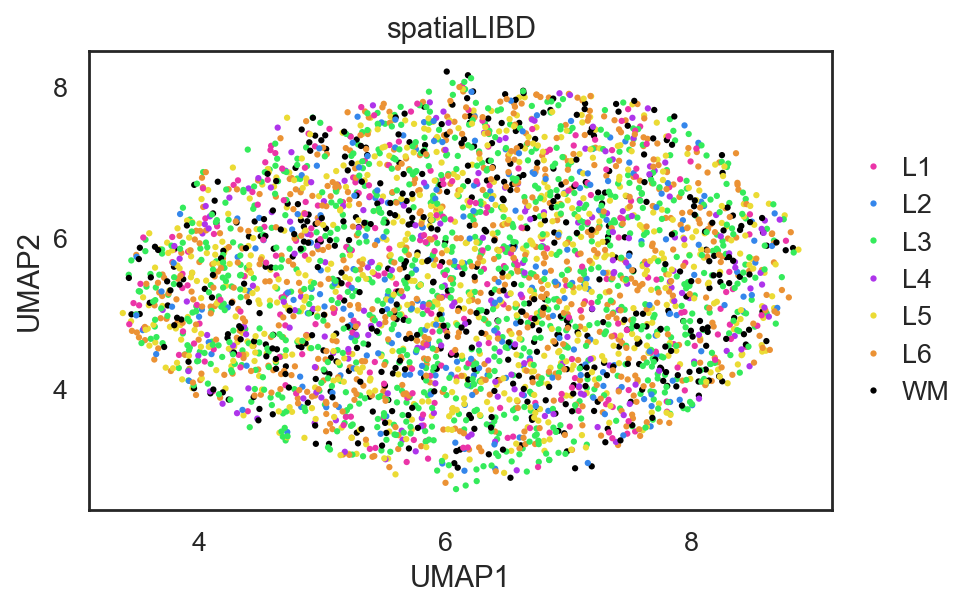

In [205]:
si.tl.umap(adata_C0_corr_zero,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C0_corr_zero,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

# Try other gammas?